In [1]:
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List,TypedDict
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,AnyMessage, RemoveMessage
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

In [2]:
model = ChatGroq(model="llama-3.1-8b-instant",temperature=0)

In [3]:
class State(TypedDict):
    messages:Annotated[List[AnyMessage],add_messages]
    summary:str

In [4]:
def assistant(state:State):
    summary = state.get("summary")
    
    if summary:
        return {"messages":model.invoke([HumanMessage(summary)]+state['messages'])}
    
    return {"messages":model.invoke(state["messages"])}

In [5]:
a = [8,9,10,11]
a[:-2]

[8, 9]

In [6]:
def summary_assistant(state:State):
    summary = state.get("summary")
    
    if summary:
        prompt = f"Given the summary {summary}. Extend it based on above messages. Keep length no longer than 100 words."
        summary = model.invoke(state["messages"]+[HumanMessage(prompt)])
    else:
        prompt = f"Summarize the above complete chat in less than 100 words"
        summary = model.invoke(state["messages"]+[HumanMessage(prompt)])
        
    
    delete_message = [RemoveMessage(id=m.id) for m in state["messages"]]
    return {"messages":delete_message,"summary":summary.content}

In [ ]:
# def router(state:State):
#     if len(state['messages']) > 6:
#         return "summary_assistant"
#     return END

In [7]:
memory = MemorySaver()

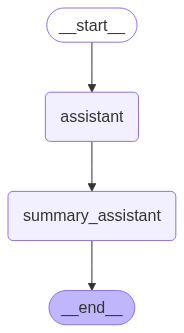

In [8]:
builder = StateGraph(State)
builder.add_node("assistant",assistant)
builder.add_node("summary_assistant",summary_assistant)

builder.add_edge(START,"assistant")
# builder.add_conditional_edges("assistant",router,{
#     "summary_assistant" : "summary_assistant",
#     END:END
# })
builder.add_edge("assistant","summary_assistant")
builder.add_edge("summary_assistant",END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable":{"thread_id":"2"}}

In [ ]:
for chunk in graph.stream({"messages":"What is our galaxy called ?"},config = config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

In [ ]:
for chunk in graph.stream({"messages":"can you tell me about galaxies"},config = config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

In [ ]:
graph.get_state(config=config)

In [ ]:
result = graph.invoke({"messages":"can you tell me about galaxies"},config = config)
result

In [ ]:
result = graph.invoke({"messages":"Earth is in which galaxy"},config = config)
result

In [ ]:
result = graph.invoke({"messages":"What is Solar System"},config = config)
result

In [ ]:
result = graph.invoke({"messages":"What is earths position with solar system"},config = config)
result

In [ ]:
result = graph.invoke({"messages":"What comes after ?"},config = config)
result

In [ ]:
result = graph.invoke({"messages":"most beautiful planet in solar system ?"},config = config)
result

In [ ]:
result['summary']

In [11]:
for chunk in graph.stream({"messages":"What is our galaxy called ?"},config = config,stream_mode="updates"):
    print(chunk)

{'assistant': {'messages': AIMessage(content='Our galaxy is called the Milky Way.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 98, 'total_tokens': 107, 'completion_time': 0.012357925, 'prompt_time': 0.005730082, 'queue_time': 0.05810783700000001, 'total_time': 0.018088007}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--4aac3095-1a11-419b-8413-a31f86315b6c-0', usage_metadata={'input_tokens': 98, 'output_tokens': 9, 'total_tokens': 107})}}
{'summary_assistant': {'messages': [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='73434dd6-21eb-47d0-a527-645c9ba62b28'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run--4aac3095-1a11-419b-8413-a31f86315b6c-0')], 'summary': "Our galaxy is called the Milky Way. It's a barred spiral galaxy with hundreds of billions of stars, interstellar gas, and dust. The Mil

In [13]:
for chunk in graph.stream({"messages":"What are black holes ?"},config = config,stream_mode="updates"):
    print(chunk)

{'assistant': {'messages': AIMessage(content="Black holes are among the most fascinating and mysterious objects in the universe. They are regions in space where the gravitational pull is so strong that nothing, including light, can escape. Here's a brief overview:\n\n**What is a black hole?**\n\nA black hole is a region in space where a massive star has collapsed in on itself, causing a massive amount of matter to be compressed into an incredibly small space. This compression creates an intense gravitational field that warps the fabric of spacetime around the black hole.\n\n**How are black holes formed?**\n\nBlack holes are formed when a massive star runs out of fuel and dies. If the star is massive enough (about 3-4 times the size of the sun), its gravity will collapse the star in on itself, causing a supernova explosion. If the star is even more massive (about 10-20 times the size of the sun), the collapse will continue, creating a singularity, a point of infinite density and zero vo

In [14]:
graph.get_state(config=config)

StateSnapshot(values={'messages': [], 'summary': 'Our galaxy, the Milky Way, is a vast, dynamic system containing hundreds of billions of stars, interstellar gas, and dust. Its diameter is approximately 100,000 light-years, with our solar system located in the outer spiral arm, the Orion Arm. At its center lies a supermassive black hole, with a mass of approximately 4 million times that of our sun. This black hole, known as Sagittarius A* (Sgr A*), is thought to have formed around 13.6 billion years ago, roughly the same age as the universe. The galaxy is constantly evolving, with stars forming and dying.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0588be-c66f-6572-800e-b49fab9d563b'}}, metadata={'source': 'loop', 'writes': {'summary_assistant': {'messages': [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='134f5ead-1322-4c32-ae9f-6434d9d7b2a6'), RemoveMessage(content='', additional_kwargs={}, response_metadat

In [ ]:
async for events in graph.astream_events({"messages":"What are black holes ?"},config = config,stream_mode="updates"):
    print(events['event']," | ",events['metadata'].get("langgraph_node")," | ",events['name'])

In [ ]:
async for events in graph.astream_events({"messages":"explain their properties in detail ?"},config = config,stream_mode="updates"):
    if events['event'] == "on_chat_model_stream" and events['metadata'].get("langgraph_node","") == "assistant":
        print(events['data']['chunk'].content,end='')

In [ ]:
async for events in graph.astream_events({"messages":"nearest black hole to earth ?"},config = config,stream_mode="updates"):
    if events['event'] == "on_chat_model_stream" and events['metadata'].get("langgraph_node","") == "summary_assistant":
        print(events['data']['chunk'].content,end='')

In [ ]:
print(len(graph.get_state(config=config).values['summary']))

In [ ]:
print(graph.get_state(config=config).values['summary'])